In [1]:
import numpy as np
import emcee 
import matplotlib.pyplot as plt
import corner 
import math

np.random.seed(42)

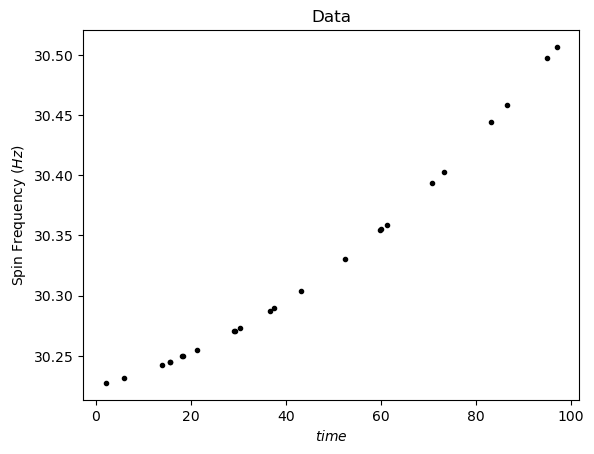

In [2]:
#No. of data points
N = 24

def dgen(x):
    return 30.225437 + 0.00095904*x + 0.5*0.00004*(x**2)

t = np.random.uniform(0, 100, N)
f = dgen(t)
ferr = np.random.uniform(0,0.00001, size=t.shape)

plt.errorbar(t,f,yerr = ferr, fmt=".k", capsize=0)
plt.title('Data')
plt.xlabel(r'$time$')
plt.ylabel(r'Spin Frequency $(Hz)$')
plt.show()

In [3]:
# Model

def model1(params, t):
    f0,f1,f2 = params
    return f0 + f1*t +f2*0.5*(t**2)
def lnlike1(p, t, y, yerr):
    return -0.5 * np.sum(((y - model1(p, t))/yerr) ** 2)

In [4]:
def lnprior1(p):
    f0,f1,f2 = p
    if (29 < f0 < 31 and  0.0009 < f1 < 0.00099 and 0.00003 < f2 < 0.00005):
        return 0.0
    return -np.inf

def lnprob1(p, x, y, yerr):
    lp = lnprior1(p)
    return lp + lnlike1(p, x, y, yerr) if np.isfinite(lp) else -np.inf

In [5]:
initial = np.array([30.22,0.00091,0.000035])
nwalkers = 240
ndim = len(initial)
data = (t,f,ferr)
p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
      for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=data)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000);

Running burn-in...
Running production...


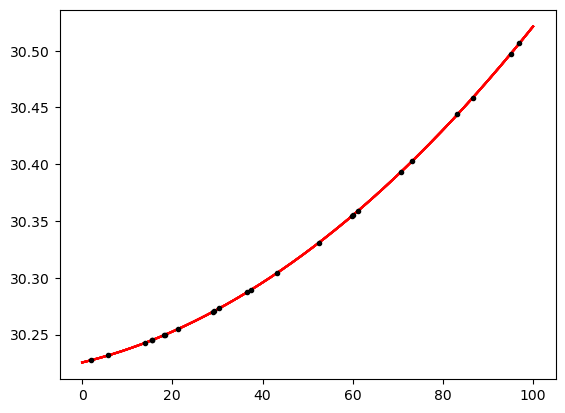

In [6]:
# Plot the data.
plt.errorbar(t, f, yerr=ferr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(0, 100, 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    plt.plot(x, model1(s, x), color="red", alpha=0.3)

In [7]:
# Extract the parameter values from the samples

for i in range(3):
    param_values = samples.T[i, :]
    mean_param = np.mean(param_values)
    std_param = np.std(param_values)

    print(f"Mean parameter: {mean_param}; Standard deviation: {std_param}")

Mean parameter: 30.225437008610456; Standard deviation: 9.62705924510626e-07
Mean parameter: 0.0009590396276575723; Standard deviation: 4.886000799284622e-08
Mean parameter: 4.000000827365149e-05; Standard deviation: 1.1439444859555651e-09


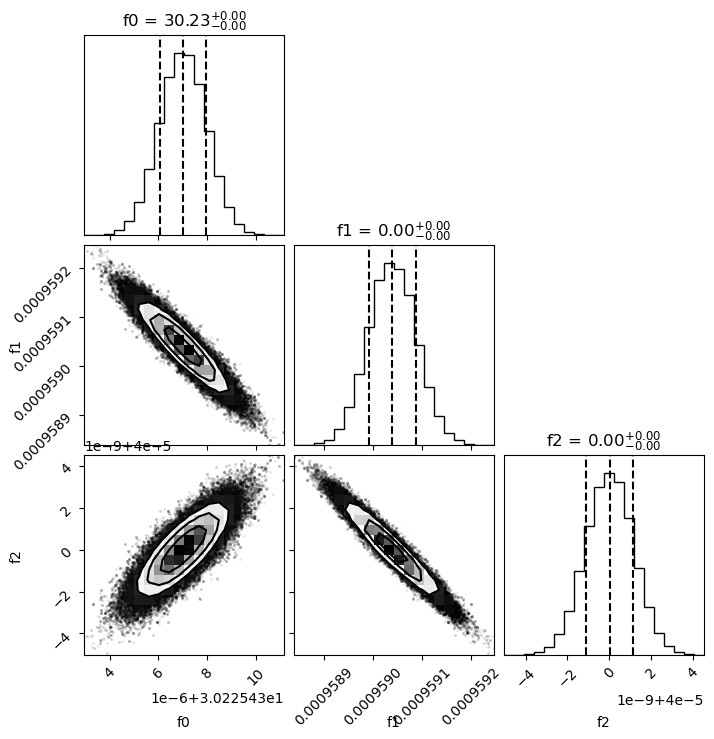

In [8]:
#Corner plots

labels = ['f0','f1','f2']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])